In [22]:
using SpecialFunctions
using QuantumOptics

function infidelity(ρ, σ)
    print(ρ, σ)
    1 - abs(ρ'*σ)^2
end

function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function Z(n, m, ρ, θ)
    if m < 0
        R(n, abs(m), ρ) * sin(abs(m) * θ)
    else
        R(n, m, ρ) * cos(m * θ)
    end
end

Z (generic function with 1 method)

In [26]:
using Cubature
σ1 = .1
σ2 = .1
function integrand(n, m)
    function rtn(coor)
        ρ = coor[1]
        θ = coor[2]
        x = ρ * cos(θ) - .25
        y = ρ * sin(θ) - .27
        Z(n, m, ρ, θ) * exp(-x^2/σ1^2 - y^2/σ2^2) * ρ
    end
    rtn
end
function neumann(m)
    if m == 0
        2
    else 
        1
    end
end
function cond_eval(n, m)
    if -n ≤ m ≤ n
        (2*n+2)/(π*neumann(m)) * hcubature(integrand(n, m), [0., 0.], [1., 2*π], maxevals=10000)[1]
    else
        0
    end
end
using Plots
gr()
maxn = 50
maxm = 30
data = hcat([[c[1] for c in [cond_eval(n, m) for n in range(0, maxn, step=1)]] for m in range(0, maxm, step=1)]...);
dataodd = hcat([[c[1] for c in [cond_eval(n, -m) for n in range(0, maxn, step=1)]] for m in range(0, maxm, step=1)]...);

In [27]:
function bessel_invert(x)
    @assert(x < .58)
    @assert(x > -.58)
    left = -1.84
    right = 1.84
    guess = besselj(1, (right+left)/2)
    while abs(guess - x) > 1E-5
        if guess < x
            left += (right - left)/2
        else
            right -= (right - left)/2
        end
        guess = besselj(1, (right+left)/2)
    end
    (right+left)/2
end
bessel_invert(-0.1)

-0.20102539062500002

In [28]:
num_points = 500
rs = LinRange(0, 1, num_points)
θs = LinRange(0, 2π, num_points)
pairs = [(r, θ) for r in rs for θ in θs]
xs = [pair[1] * cos(pair[2]) for pair in pairs]
ys = [pair[1] * sin(pair[2]) for pair in pairs]
xs = LinRange(-1, 1, num_points)
ys = LinRange(-1, 1, num_points)

500-element LinRange{Float64}:
 -1.0,-0.995992,-0.991984,-0.987976,-0.983968,…,0.987976,0.991984,0.995992,1.0

In [29]:
interionic_spacing = .1
up_modifier = sqrt(3)/2 * interionic_spacing
over_modifer = 1/2 * interionic_spacing
points_inside_circle = []
digits = 2
radius = .5
function gen_points(pt, points_inside_circle, x, y)
    pt = [round(pt[1], digits=digits), round(pt[2], digits=digits)]
    if pt in points_inside_circle || pt[1]^2 + pt[2]^2 > radius^2
        return
    else
        push!(points_inside_circle, pt)
        push!(x, pt[1])
        push!(y, pt[2])
        gen_points([pt[1] + over_modifer, pt[2] - up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] - over_modifer, pt[2] - up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] - over_modifer, pt[2] + up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] + over_modifer, pt[2] + up_modifier], points_inside_circle, x, y)
        gen_points([pt[1] + interionic_spacing, pt[2]], points_inside_circle, x, y)
        gen_points([pt[1] + interionic_spacing, pt[2]], points_inside_circle, x, y)
        gen_points([pt[1] - interionic_spacing, pt[2]], points_inside_circle, x, y)
        return points_inside_circle, x, y
    end
end
pairs, x, y = gen_points([0, 0], [], [], [])
function circleShape(h, k, r)
    θ = LinRange(0, 2*π, 500)
    h .+ r*sin.(θ), k .+ r*cos.(θ)
end
using Plots
gr() # We will continue onward using the GR backend
plot(x, y, seriestype = :scatter, title = "Top View of Penning Trap")
plot!(circleShape(0, 0, .5), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=.2, aspect_ratio = 1, axis=nothing, border=:none);


In [30]:
function plot_triangles_across_unit_disk(f, x, y)
    infids = []
    ψ1s = []
    ψ2s = []
    for (i, xx) in enumerate(x)
        print(i)
        ρ = sqrt(xx^2 + y[i]^2)
        ϕ = atan(y[i], xx)
        infid, ψ1, ψ2 = f(ρ, ϕ)
        push!(infids, infid)
        push!(ψ1s, ψ1)
        push!(ψ2s, ψ2)
        end
    infids, ψ1s, ψ2s
end

plot_triangles_across_unit_disk (generic function with 1 method)

In [31]:
function sample_across_unit_disk(f, discretization)
    x = y = Array(range(0, 1, length=discretization))
    z = Array{typeof(f(0.,0.))}(UndefInitializer(), length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            if xx^2 + yy^2 > 1
                if typeof(f(0.,0.)) == Tuple{Float64,Float64}
                    z[i, j] = (0.,0.)
                else
                    z[i, j] = 0.
                end
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)
                res = f(ρ, ϕ)
                z[i, j] = res
            end
        end
    end
    x, y, z
end

sample_across_unit_disk (generic function with 1 method)

In [287]:
maxn = 32
maxm=10
lookupeven = Dict()
lookupodd = Dict()
for n in range(0, maxn, step=1)
    for m in range(0, maxm, step=1)
        if n >= m
            for (i, pair) in enumerate(collect(zip(x, y)))
                xx = pair[1]
                yy = pair[2]
                ρ = sqrt(xx^2 + yy^2)
                # lookup with five digits of accuracy
                ρ = Int(round(ρ * 10^3, digits=0))
                lookupeven[(ρ, n, m)] = Float64(data[n+1, m+1] * R(n, m, sqrt(xx^2 + yy^2)))
                lookupodd[(ρ, n, m)] = Float64(dataodd[n+1, m+1] * R(n, m, sqrt(xx^2 + yy^2)))
            end
        end
    end
end
ω = 2*π*180E3
θ = -π/2;
U = 2 * π * 10E3
amp = 4.1
evolution_time = π/(2*U*amp)
finals = []
raws = []
for (i, xx) in enumerate(x)
    yy = y[i]
    ρ = sqrt(xx^2 + yy^2)
    ϕ = atan(yy, xx)
    final = 0
    ρ = Int(round(ρ * 10^3, digits=0))
    for m in range(0, maxm, step=1)
        pm = 0
        for n in range(0, maxn, step=1)
            if n ≥ m
                pm += lookupeven[(ρ, n, m)]
            end
        end
        inverted = bessel_invert(amp*pm)
        total = U*besselj(1, inverted)*sin(m*ϕ-θ)*evolution_time
        maxpower = 100
        for k in range(-maxpower, maxpower, step=1)
            if k!=1 && m!=0
                a = U*exp(1.0im * (θ - k*m*ϕ)) * (1.0im)^(k+1)/(2*(k-1)*m*ω) * besselj(k, inverted)*(1 - exp(-1.0im*(k-1)*m*ω*evolution_time))
                total += a + conj(a)
            end
        end
        final += total
    end 
    for m in range(0, maxm, step=1)
        pm = 0
        for n in range(0, maxn, step=1)
            if n ≥ m
                pm += lookupodd[(ρ, n, m)]
            end
        end
        inverted = bessel_invert(amp*pm)
        total = -U*besselj(1, inverted)*cos(m*ϕ-θ)*evolution_time
        maxpower = 100
        for k in range(-maxpower, maxpower, step=1)
            if k!=1 && m!=0 
                a = 1.0im*U*exp(1.0im * (θ - k*m*ϕ)) * (-1.0)^(k+1)/(2*(k-1)*m*ω) * besselj(k, inverted)*(1 - exp(-1.0im*(k-1)*m*ω*evolution_time))
                total += a + conj(a)
            end
        end
        final += total
    end
    push!(finals, final)
end

In [288]:
evolution_time

6.0975609756097564e-6

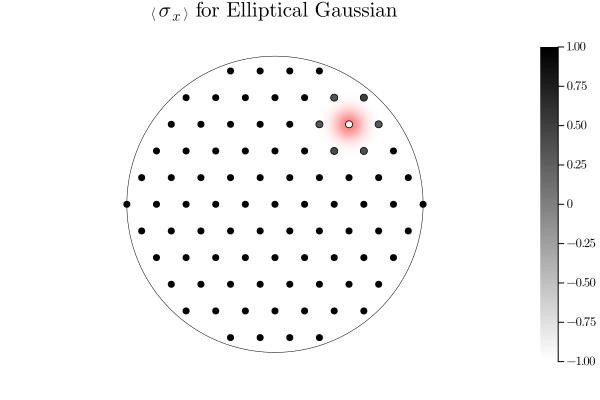

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498
┌ Warning: Multiple series with different fill alpha share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498


In [256]:
σ1 = .1
σ2 = .1
using LaTeXStrings
scale = 2
function gaussian(σ1, σ2)
    function func(x, y)
        y -= .27 * scale
        x -= .25 * scale
        if x^2 + y^2 > (1)^2
            -1
        else
        2*exp(-x^2/(σ1)^2 + -y^2/(σ2)^2) - 1
        end
    end
end


p = palette([:white, :black], 100);

plot(heatmap(xs, ys, gaussian(σ1, σ2); c=palette([:white, :red], 100), alpha=.5))
scatter!(scale*x, scale*y, marker_z = [Real(cos(2*f)) for f in finals], c=p, clim  = (-1,1))
plot!(circleShape(0, 0, scale*radius), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=0, aspect_ratio = 1, axis=nothing, border=:none, title=L"\left\langle\sigma_x\right\rangle\textrm{ for Elliptical Gaussian}", fontfamily="Computer Modern")

In [257]:
minimum([Real(cos(2*f)) for f in finals])

-0.9801820526411024

In [258]:
function gaussian(σ1, σ2)
    function func(x, y)
        x-=.25
        y-=.27
        1/sqrt(2) * [exp(-1.0im * π/2 * exp(-x^2/σ1^2 + -y^2/σ2^2)), exp(1.0im * π/2 * exp(-x^2/σ1^2 + -y^2/σ2^2))]
    end
end


ϕ = [gaussian(σ1, σ2)(xx, y[i]) for (i, xx) in enumerate(x)];
ψ = [1/sqrt(2)*[exp(-1.0im * (f)), exp(1.0im * (f))] for f in finals];
infidsparallel = [infidelity(ϕϕ, ψ[i]) for (i, ϕϕ) in enumerate(ϕ)];
#infidsparallel = [Real(ϕϕ'*[0 1; 1 0]*ϕϕ) for (i, ϕϕ) in enumerate(ϕ)];


Complex{Float64}[0.7071067811850339 - 1.463044696700747e-6im, 0.7071067811850339 + 1.463044696700747e-6im]Complex{Float64}[0.7070959758694384 + 0.003909080358169409im, 0.7070959758694384 - 0.003909080358169409im]Complex{Float64}[0.7071067811865458 - 4.785975445373536e-8im, 0.7071067811865458 + 4.785975445373536e-8im]Complex{Float64}[0.7071067163684467 - 0.00030276497972608934im, 0.7071067163684467 + 0.00030276497972608934im]Complex{Float64}[0.7071067811865475 - 1.8792261033730932e-10im, 0.7071067811865475 + 1.8792261033730932e-10im]Complex{Float64}[0.7071062293936461 - 0.0008833757412712805im, 0.7071062293936461 + 0.0008833757412712805im]Complex{Float64}[0.7071067811865475 - 8.856931890805878e-14im, 0.7071067811865475 + 8.856931890805878e-14im]Complex{Float64}[0.7067028766339358 + 0.023896530235998047im, 0.7067028766339358 - 0.023896530235998047im]Complex{Float64}[0.7071067811865475 - 5.010525445317965e-18im, 0.7071067811865475 + 5.010525445317965e-18im]Complex{Float64}[0.7069700262449

 + 0.002182790063096022im]Complex{Float64}[0.7071067811858941 - 9.612888652149015e-7im, 0.7071067811858941 + 9.612888652149015e-7im]Complex{Float64}[0.7070924215387137 + 0.004506373543990276im, 0.7070924215387137 - 0.004506373543990276im]Complex{Float64}[0.7071067811865475 - 1.3885707100398634e-9im, 0.7071067811865475 + 1.3885707100398634e-9im]Complex{Float64}[0.7071065951749784 - 0.000512893799028141im, 0.7071065951749784 + 0.000512893799028141im]Complex{Float64}[0.7071067811865475 - 2.407563701467703e-13im, 0.7071067811865475 + 2.407563701467703e-13im]Complex{Float64}[0.7063357473914897 + 0.033012300085051086im, 0.7063357473914897 - 0.033012300085051086im]Complex{Float64}[0.7071067811865475 - 5.010525445317965e-18im, 0.7071067811865475 + 5.010525445317965e-18im]Complex{Float64}[0.7069970269205876 + 0.012458086749171031im, 0.7069970269205876 - 0.012458086749171031im]Complex{Float64}[0.7071067811865475 - 8.856931890805878e-14im, 0.7071067811865475 + 8.856931890805878e-14im]Complex{Floa

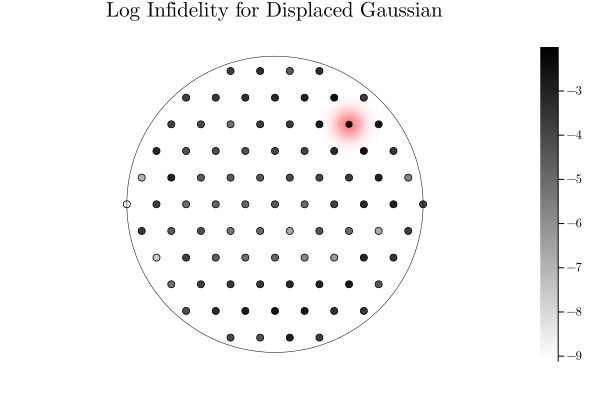

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498
┌ Warning: Multiple series with different fill alpha share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498


In [259]:
σ1 = .1
σ2 = .1
using LaTeXStrings

function gaussian(σ1, σ2, z)
    function func(x, y)
        x-=.25*2
        y-=.27*2
        (maximum(log.(10, z)) - minimum(log.(10, z)))*exp(-x^2/σ1^2 + -y^2/σ2^2) + minimum(log.(10, z))
    end
end


p = palette([:white, :black], 100);
scale = 2
plot(heatmap(xs, ys, gaussian(σ1, σ2, infidsparallel); c=palette([:white, :red], 100), alpha=.5))
scatter!(scale*x, scale*y, marker_z = [log(10, Real(infid)) for infid in infidsparallel], c=p)
plot!(circleShape(0, 0, scale*radius), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=0, aspect_ratio = 1, axis=nothing, border=:none, title=L"\textrm{Log Infidelity for Displaced Gaussian}", fontfamily="Computer Modern")

In [260]:
1-maximum([Real(infid) for infid in infidsparallel])

0.9900910263205509

# Completely Serial

In [309]:
maxn = 40
maxm=13
lookupeven = Dict()
lookupodd = Dict()
for n in range(0, maxn, step=1)
    for m in range(0, maxm, step=1)
        if n >= m
            for (i, pair) in enumerate(collect(zip(x, y)))
                xx = pair[1]
                yy = pair[2]
                ρ = sqrt(xx^2 + yy^2)
                # lookup with five digits of accuracy
                ρ = Int(round(ρ * 10^3, digits=0))
                lookupeven[(ρ, n, m)] = Float64(data[n+1, m+1] * R(n, m, sqrt(xx^2 + yy^2)))
                lookupodd[(ρ, n, m)] = Float64(dataodd[n+1, m+1] * R(n, m, sqrt(xx^2 + yy^2)))
            end
        end
    end
end
ω = 2*π*180E3
θ = -π/2;
U = 2 * π * 10E3
amp = .1
evolution_time = π/(U*amp)
finals = []
for (i, xx) in enumerate(x)
    yy = y[i]
    ρ = sqrt(xx^2 + yy^2)
    ϕ = atan(yy, xx)
    final = 0
    ρ = Int(round(ρ * 10^3, digits=0))
    for m in range(0, maxm, step=1)
        for n in range(0, maxn, step=1)
            pmn = 0
            if n ≥ m
                pmn += lookupeven[(ρ, n, m)]
            end
            inverted = bessel_invert(amp*pmn)
            total = U*besselj(1, amp*pmn)*sin(m*ϕ-θ)*evolution_time
            maxpower = 100
            for k in range(-maxpower, maxpower, step=1)
                if k!=1 && m!=0
                    a = U*exp(1.0im * (θ - k*m*ϕ)) * (1.0im)^(k+1)/(2*(k-1)*m*ω) * besselj(k, amp*pmn)*(1 - exp(-1.0im*(k-1)*m*ω*evolution_time))
                    total += a + conj(a)
                end
            end
            final += total
        end
    end 
    for m in range(0, maxm, step=1)
        for n in range(0, maxn, step=1)
            pmn = 0
            if n ≥ m
                pmn += lookupodd[(ρ, n, m)]
            end
            inverted = bessel_invert(amp*pmn)
            total = -U*besselj(1, amp*pmn)*cos(m*ϕ-θ)*evolution_time
            maxpower = 100
            for k in range(-maxpower, maxpower, step=1)
                if k!=1 && m!=0
                    a = 1.0im*U*exp(1.0im * (θ - k*m*ϕ)) * (-1.0)^(k+1)/(2*(k-1)*m*ω) * besselj(k, amp*pmn)*(1 - exp(-1.0im*(k-1)*m*ω*evolution_time))
                    total += a + conj(a)
                end
            end
        final += total
        end
    end
    push!(finals, final)
end

In [310]:
evolution_time

0.005

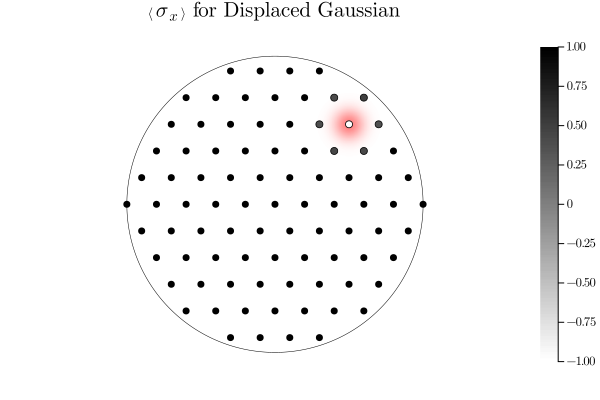

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498
┌ Warning: Multiple series with different fill alpha share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498


In [311]:
σ1 = .1
σ2 = .1
using LaTeXStrings

scale = 2
function gaussian(σ1, σ2)
    function func(x, y)
        y -= .27 * scale
        x -= .25 * scale
        if x^2 + y^2 > (1)^2
            -1
        else
        2*exp(-x^2/(σ1)^2 + -y^2/(σ2)^2) - 1
        end
    end
end

p = palette([:white, :black], 100);
scale = 2
plot(heatmap(xs, ys, gaussian(σ1, σ2); c=palette([:white, :red], 100), alpha=.5))
scatter!(scale*x, scale*y, marker_z = [Real(cos(2*f)) for f in finals], c=p, clim  = (-1,1))
plot!(circleShape(0, 0, scale*radius), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=0, aspect_ratio = 1, axis=nothing, border=:none, title=L"\left\langle\sigma_x\right\rangle\textrm{ for Displaced Gaussian}", fontfamily="Computer Modern")

In [312]:
function gaussian(σ1, σ2)
    function func(x, y)
        x-=.25
        y-=.27
        1/sqrt(2) * [exp(-1.0im * π/2 * exp(-x^2/σ1^2 + -y^2/σ2^2)), exp(1.0im * π/2 * exp(-x^2/σ1^2 + -y^2/σ2^2))]
    end
end



ϕ = [gaussian(σ1, σ2)(xx, y[i]) for (i, xx) in enumerate(x)];
ψ = [1/sqrt(2)*[exp(-1.0im * (f)), exp(1.0im * (f))] for f in finals];
infids = [infidelity(ϕϕ, ψ[i]) for (i, ϕϕ) in enumerate(ϕ)];

Complex{Float64}[0.7071067811850339 - 1.463044696700747e-6im, 0.7071067811850339 + 1.463044696700747e-6im]Complex{Float64}[0.7071062862631453 - 0.0008366164847881114im, 0.7071062862631453 + 0.0008366164847881114im]Complex{Float64}[0.7071067811865458 - 4.785975445373536e-8im, 0.7071067811865458 + 4.785975445373536e-8im]Complex{Float64}[0.7071067811840426 + 1.8821126674364812e-6im, 0.7071067811840426 - 1.8821126674364812e-6im]Complex{Float64}[0.7071067811865475 - 1.8792261033730932e-10im, 0.7071067811865475 + 1.8792261033730932e-10im]Complex{Float64}[0.70710670527903 + 0.00032764223624218267im, 0.70710670527903 - 0.00032764223624218267im]Complex{Float64}[0.7071067811865475 - 8.856931890805878e-14im, 0.7071067811865475 + 8.856931890805878e-14im]Complex{Float64}[0.7071042320054111 + 0.0018987048316452225im, 0.7071042320054111 - 0.0018987048316452225im]Complex{Float64}[0.7071067811865475 - 5.010525445317965e-18im, 0.7071067811865475 + 5.010525445317965e-18im]Complex{Float64}[0.7070792387639

[0.7071061162575126 + 0.0009697170808636301im, 0.7071061162575126 - 0.0009697170808636301im]Complex{Float64}[0.7071067811858941 - 9.612888652149015e-7im, 0.7071067811858941 + 9.612888652149015e-7im]Complex{Float64}[0.7071059687384909 - 0.0010719022345258382im, 0.7071059687384909 + 0.0010719022345258382im]Complex{Float64}[0.7071067811865475 - 1.3885707100398634e-9im, 0.7071067811865475 + 1.3885707100398634e-9im]Complex{Float64}[0.7071065309837934 + 0.000594844572639375im, 0.7071065309837934 - 0.000594844572639375im]Complex{Float64}[0.7071067811865475 - 2.407563701467703e-13im, 0.7071067811865475 + 2.407563701467703e-13im]Complex{Float64}[0.7070781060496616 - 0.00636804092506606im, 0.7070781060496616 + 0.00636804092506606im]Complex{Float64}[0.7071067811865475 - 5.010525445317965e-18im, 0.7071067811865475 + 5.010525445317965e-18im]Complex{Float64}[0.7071003699812308 - 0.0030111081691541453im, 0.7071003699812308 + 0.0030111081691541453im]Complex{Float64}[0.7071067811865475 - 8.856931890805

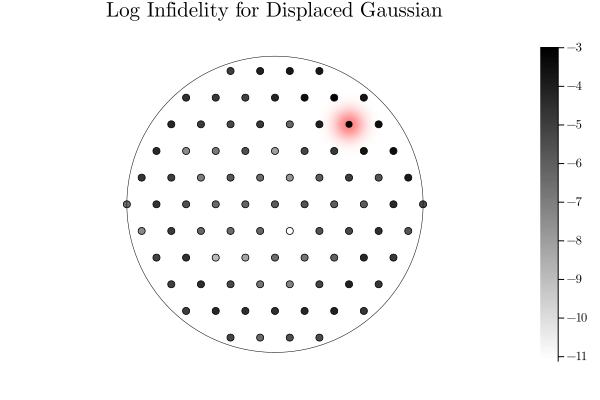

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498
┌ Warning: Multiple series with different fill alpha share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /home/ampolloreno/.julia/packages/Plots/oZheM/src/backends/gr.jl:498


In [313]:
σ1 = .1
σ2 = .1
using LaTeXStrings

function gaussian(σ1, σ2, z)
    function func(x, y)
        x-=.25*2
        y-=.27*2
        (maximum(log.(10, z)) - minimum(log.(10, z)))*exp(-x^2/σ1^2 + -y^2/σ2^2) + minimum(log.(10, z))
    end
end


p = palette([:white, :black], 100);
scale = 2
plot(heatmap(xs, ys, gaussian(σ1, σ2, infids); c=palette([:white, :red], 100), alpha=.5))
scatter!(scale*x, scale*y, marker_z = [log(10, Real(infid)) for infid in infids], c=p)
plot!(circleShape(0, 0, scale*radius), seriestype = [:shape,], lw = .5, c=:blue, lincolor = :black, legend=false, fillalpha=0, aspect_ratio = 1, axis=nothing, border=:none, title=L"\textrm{Log Infidelity for Displaced Gaussian}", fontfamily="Computer Modern")

In [314]:
maximum([log(10, Real(infid)) for infid in infids])

-2.981217941303006

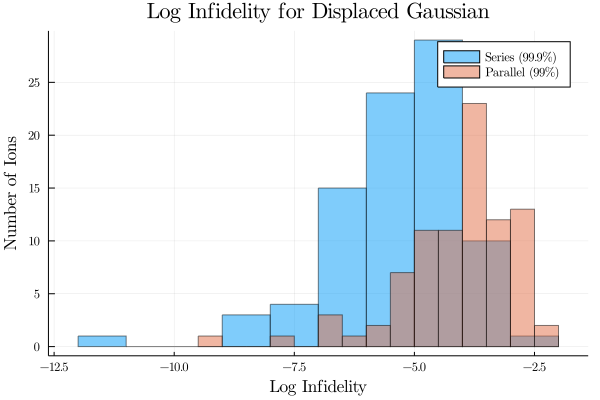

In [294]:
σ1 = .1
σ2 = .1  
using LaTeXStrings
using Plots

histogram(log.(10, infids), alpha=.5, label="Series (99.9%)", xlabel="Log Infidelity", ylabel="Number of Ions", title="Log Infidelity for Displaced Gaussian",  fontfamily="Computer Modern")
#histogram!(log.(10, z2), alpha=.5, label="")
histogram!(log.(10, infidsparallel), alpha=.5, label="Parallel (99%)")